##Import Libraries

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,GlobalAveragePooling1D,GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

## Download required files

In [7]:
# Download helper function
!wget https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py

--2023-09-16 20:27:06--  https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-16 20:27:06 (89.4 MB/s) - ‘helper_function.py’ saved [10246/10246]



In [8]:
# Import series of helper functions for the notebook
from helper_function import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [60]:
# Download dataset
!wget https://raw.githubusercontent.com/SNNJM/TF_DL_SkillsChecklist/main/4_NLP/dataset/Consumer_Complaints.csv

--2023-09-16 21:26:42--  https://raw.githubusercontent.com/SNNJM/TF_DL_SkillsChecklist/main/4_NLP/dataset/Consumer_Complaints.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137540 (134K) [text/plain]
Saving to: ‘Consumer_Complaints.csv’

Consumer_Complaints 100%[===================>] 134.32K  --.-KB/s    in 0.002s  

2023-09-16 21:26:43 (60.1 MB/s) - ‘Consumer_Complaints.csv’ saved [137540/137540]



## Visualizing dataset

In [61]:
df = pd.read_csv('/content/Consumer_Complaints.csv')


In [62]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,Company chooses not to provide a public response,Experian Information Solutions Inc.,VA,224XX,NaN,Consent provided,Web,6/15/2015,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,NaN,"The CBE Group, Inc.",TX,752XX,NaN,Consent provided,Web,2/3/2016,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,Company has responded to the consumer and the ...,SQUARETWO FINANCIAL CORPORATION,NE,693XX,NaN,Consent provided,Web,3/4/2016,Closed with explanation,Yes,Yes,1790634


In [180]:
df.describe()

,Complaint ID
count,1.050000e+02
mean,1.973987e+06
std,3.818401e+05
min,1.297495e+06
25%,1.688961e+06
50%,1.992309e+06
75%,2.283195e+06
max,2.587037e+06


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 106 non-null    object
 1   Product                       106 non-null    object
 2   Sub-product                   75 non-null     object
 3   Issue                         106 non-null    object
 4   Sub-issue                     60 non-null     object
 5   Consumer complaint narrative  106 non-null    object
 6   Company public response       54 non-null     object
 7   Company                       106 non-null    object
 8   State                         106 non-null    object
 9   ZIP code                      106 non-null    object
 10  Tags                          21 non-null     object
 11  Consumer consent provided?    106 non-null    object
 12  Submitted via                 106 non-null    object
 13  Date sent to company

In [64]:
df.Product.value_counts()

Debt collection                                                                 28
Credit reporting                                                                23
Mortgage                                                                        23
Credit card                                                                      8
Bank account or service                                                          7
Student loan                                                                     5
Consumer Loan                                                                    4
Money transfers                                                                  3
Credit reporting, credit repair services, or other personal consumer reports     3
Other financial service                                                          1
Credit card or prepaid card                                                      1
Name: Product, dtype: int64

In [84]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [85]:
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints',
                                                                title='Number complaints in each product')

In [86]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [87]:
print_plot(99)

three months ago disputed bankruptcy lien information listed credit report equifa listed verified provided actual validation verified source effectively new consumer bill propose changes credit reporting scoring specific information required determined accuracy reported reaching county clerk record county regarding information credit report process verified public inspection working hours special provisions made reporting agencies would like concrete proof liens bankruptcies indeed accounts mine promptly remove
Product: Credit reporting, credit repair services, or other personal consumer reports


##Pre-processing dataset

In [88]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

In [89]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

<ipython-input-89-40704303c81a>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [90]:
print_plot(99)

three months ago disputed bankruptcy lien information listed credit report equifa listed verified provided actual validation verified source effectively new consumer bill propose changes credit reporting scoring specific information required determined accuracy reported reaching county clerk record county regarding information credit report process verified public inspection working hours special provisions made reporting agencies would like concrete proof liens bankruptcies indeed accounts mine promptly remove
Product: Credit reporting, credit repair services, or other personal consumer reports


### Tokenization

Tokenization is the process of splitting text to individual elements (character, word, sentence, etc).

The result of Tokenizer is then used to convert to integer sequences using texts_to_sequences.

On the other hand tf.keras.layers.TextVectorization converts the text to integer sequences.

#### Word embedding

In [122]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))




Found 2157 unique tokens.


In [123]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (105, 250)


In [124]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (105, 8)


### Split data

In [125]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(94, 250) (94, 8)
(11, 250) (11, 8)


## Model Creation

### Baseline

In [159]:
# Create model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.add(GlobalAveragePooling1D())

#Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit
epochs = 50
batch_size = 64

history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    validation_data=(X_test,Y_test))




Epoch 1/50
3/3 [==============================] - 2s 308ms/step - loss: 2.0746 - accuracy: 0.1915 - val_loss: 2.0631 - val_accuracy: 0.2727
Epoch 2/50
3/3 [==============================] - 1s 192ms/step - loss: 2.0504 - accuracy: 0.3191 - val_loss: 2.0525 - val_accuracy: 0.2727
Epoch 3/50
3/3 [==============================] - 1s 197ms/step - loss: 2.0300 - accuracy: 0.2979 - val_loss: 2.0423 - val_accuracy: 0.2727
Epoch 4/50
3/3 [==============================] - 1s 221ms/step - loss: 2.0104 - accuracy: 0.3298 - val_loss: 2.0303 - val_accuracy: 0.2727
Epoch 5/50
3/3 [==============================] - 1s 191ms/step - loss: 1.9883 - accuracy: 0.3298 - val_loss: 2.0177 - val_accuracy: 0.2727
Epoch 6/50
3/3 [==============================] - 0s 123ms/step - loss: 1.9635 - accuracy: 0.3404 - val_loss: 2.0052 - val_accuracy: 0.2727
Epoch 7/50
3/3 [==============================] - 1s 374ms/step - loss: 1.9386 - accuracy: 0.3404 - val_loss: 1.9920 - val_accuracy: 0.1818
Epoch 8/50
3/3 [====

In [137]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 dense_29 (Dense)            (None, 250, 100)          10100     
                                                                 
 dropout_1 (Dropout)         (None, 250, 100)          0         
                                                                 
 dense_30 (Dense)            (None, 250, 8)            808       
                                                                 
 global_average_pooling1d_3  (None, 8)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 5010908 (19.12 MB)
Trainable params: 5010908 (19.12 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [164]:
# Model performance on test data
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 25ms/step - loss: 2.1164 - accuracy: 0.3636


[2.1163535118103027, 0.3636363744735718]

In [142]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### LSTM

* The first layer is the embedded layer that uses 100 length vectors to represent each word.
* SpatialDropout1D performs variational dropout in NLP models.
* The next layer is the LSTM layer with 100 memory units.
* The output layer must create 13 output values, one for each class.
* Activation function is softmax for multi-class classification.
* Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [162]:
# Create model
model1 = Sequential()
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(8, activation='softmax'))

#Compile
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit
epochs = 50
batch_size = 64

history1 = model1.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    validation_data=(X_test,Y_test))



Epoch 1/50
3/3 [==============================] - 8s 2s/step - loss: 2.0749 - accuracy: 0.2340 - val_loss: 2.0708 - val_accuracy: 0.1818
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 2.0448 - accuracy: 0.5106 - val_loss: 2.0592 - val_accuracy: 0.0909
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 2.0051 - accuracy: 0.4894 - val_loss: 2.0304 - val_accuracy: 0.0909
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 1.8970 - accuracy: 0.3298 - val_loss: 1.9813 - val_accuracy: 0.1818
Epoch 5/50
3/3 [==============================] - 3s 1s/step - loss: 1.7224 - accuracy: 0.2553 - val_loss: 2.0561 - val_accuracy: 0.1818
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 1.6511 - accuracy: 0.4468 - val_loss: 1.9660 - val_accuracy: 0.0909
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 1.6131 - accuracy: 0.4362 - val_loss: 2.0024 - val_accuracy: 0.0909
Epoch 8/50
3/3 [=========================

In [163]:
# Model performance on test data
model1.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 80ms/step - loss: 1.8982 - accuracy: 0.6364


[1.8982447385787964, 0.6363636255264282]

In [143]:
model1.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### GRU & RNN

In [175]:
from keras import layers
from tensorflow.keras.layers import GRU,SimpleRNN


# Create model
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(layers.GRU(64, return_sequences=True))
model2.add(layers.SimpleRNN(64))
model2.add(Dense(8, activation='softmax'))

#Compile
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit
epochs = 50
batch_size = 64

history2 = model2.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    validation_data=(X_test,Y_test))




Epoch 1/50
3/3 [==============================] - 6s 662ms/step - loss: 2.0895 - accuracy: 0.1064 - val_loss: 2.0716 - val_accuracy: 0.1818
Epoch 2/50
3/3 [==============================] - 1s 392ms/step - loss: 1.8486 - accuracy: 0.5532 - val_loss: 2.0294 - val_accuracy: 0.2727
Epoch 3/50
3/3 [==============================] - 1s 378ms/step - loss: 1.6217 - accuracy: 0.8723 - val_loss: 2.0408 - val_accuracy: 0.1818
Epoch 4/50
3/3 [==============================] - 1s 445ms/step - loss: 1.3942 - accuracy: 0.9681 - val_loss: 2.0833 - val_accuracy: 0.0909
Epoch 5/50
3/3 [==============================] - 1s 408ms/step - loss: 1.1812 - accuracy: 0.9894 - val_loss: 2.0638 - val_accuracy: 0.1818
Epoch 6/50
3/3 [==============================] - 1s 402ms/step - loss: 0.9864 - accuracy: 1.0000 - val_loss: 2.1978 - val_accuracy: 0.0909
Epoch 7/50
3/3 [==============================] - 1s 388ms/step - loss: 0.8327 - accuracy: 0.9894 - val_loss: 2.0391 - val_accuracy: 0.1818
Epoch 8/50
3/3 [====

In [176]:
# Model performance on test data
model2.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 61ms/step - loss: 2.4664 - accuracy: 0.0909


[2.4664361476898193, 0.09090909361839294]

In [177]:
model2.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## Plot Loss curve

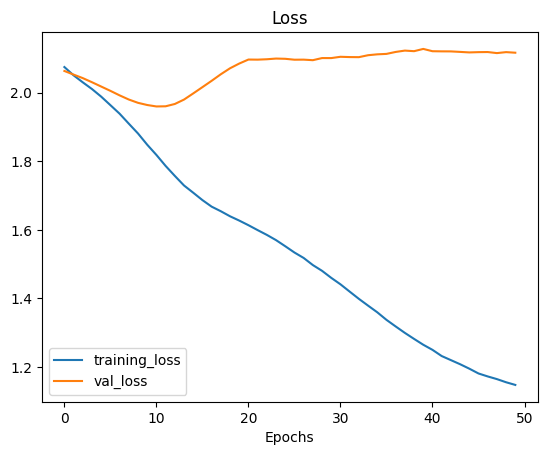

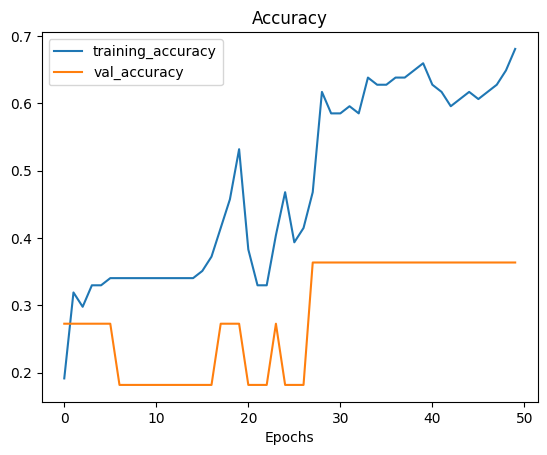

In [167]:
# Check out the loss & accuracy curves of baseline model
plot_loss_curves(history)

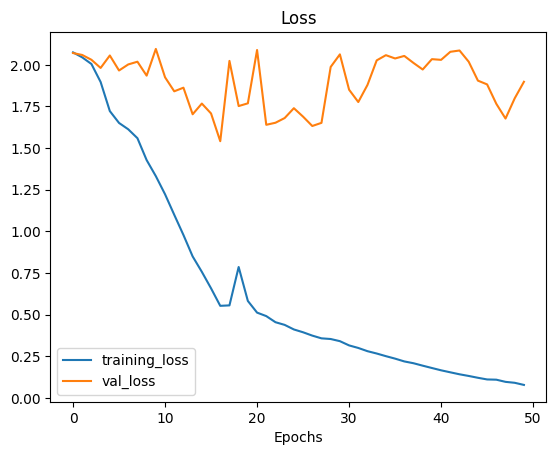

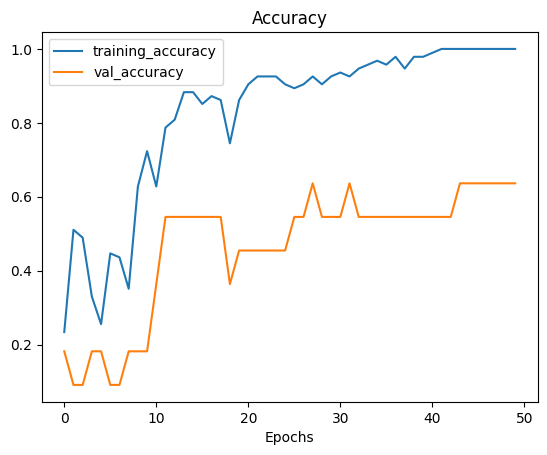

In [168]:
# Check out the loss & accuracy curves of LSTM model
plot_loss_curves(history1)

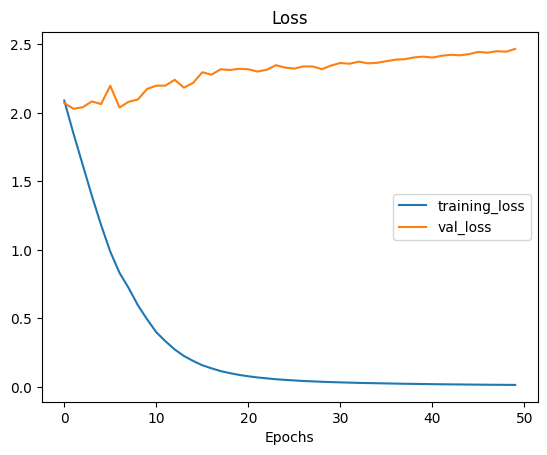

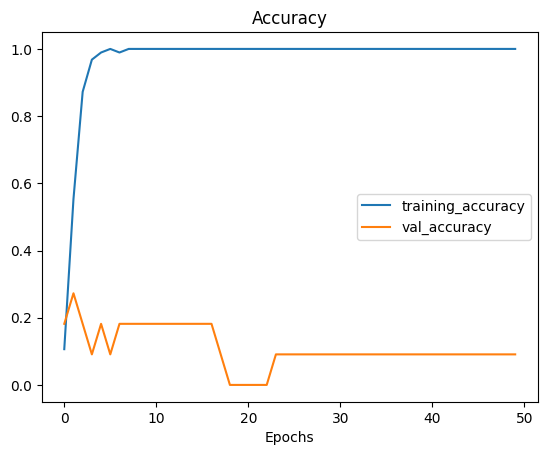

In [178]:
# Check out the loss & accuracy curves of GRU & RNN model
plot_loss_curves(history2)